In [1]:
ls

Aggregation.txt              Compound.txt              R15.txt36frames.gif
Aggregation.txt12frames.gif  Compound.txt22frames.gif  README.md
Aggregation.txt20frames.gif  D31.txt                   spiral20frames.mp4
Aggregation.txt22frames.gif  D31.txt22frames.gif       spiral40frames.mp4
Aggregation.txt3frames.gif   jain40frames.mp4          spiral.txt
animation-400.mp4            jain.txt                  spiral.txt19frames.gif
animation-b.mp4              jain.txt20frames.gif      spiral.txt20frames.gif
animation-c.mp4              pogo.ipynb                spiral.txt29frames.gif
animation-d.mp4              R15.txt                   spiral.txt49frames.gif
animation.gif                R15.txt17frames.gif       spiral.txt5frames.gif
animation.mp4                R15.txt22frames.gif


In [2]:
import numpy as np
import pandas as pd
import gudhi

In [3]:
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib import animation
from matplotlib.collections import PatchCollection

In [4]:
from sklearn.datasets import make_blobs
from sklearn.datasets import make_classification
from sklearn.datasets import make_gaussian_quantiles
from sklearn.datasets import load_iris
from sklearn.datasets import load_digits


from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn import metrics

import os.path

In [5]:
from urllib.request import urlopen
from urllib.parse import urlparse

In [6]:
%matplotlib inline

#randomized blobs with standard deviation
n = 6
std = np.random.random_sample((n,))
#std = 1
X, y, z = make_blobs(
    n_samples=n*100,
    n_features=2,
    centers=n,
    cluster_std=std,
    center_box=(-10.0, 10.0),
    shuffle=False,
    random_state=42,
    return_centers=True,
)



size=8
plt.figure(figsize=(size,size))
plt.scatter(X[:, 0], X[:, 1],
            s=25, 
            c=y,
            marker="o",
            cmap='tab10',
            norm=None,
            alpha=.7,
            edgecolor="k")

In [7]:
urls = ['https://cs.joensuu.fi/sipu/datasets/D31.txt',
        'https://cs.joensuu.fi/sipu/datasets/spiral.txt',
        'https://cs.joensuu.fi/sipu/datasets/overlap.txt',
        'https://cs.joensuu.fi/sipu/datasets/pathbased.txt',
        'https://cs.joensuu.fi/sipu/datasets/a1.txt',
        'https://cs.joensuu.fi/sipu/datasets/R15.txt',
        'https://cs.joensuu.fi/sipu/datasets/unbalance.txt']

In [8]:
url= urls[5]
print(url)
parse = urlparse(url)
filename = parse.path.strip('/').split('/')[-1]
print(filename)
raw_data = urlopen(url)
data = np.loadtxt(raw_data)

print(data.shape)
print(data[:10])


https://cs.joensuu.fi/sipu/datasets/R15.txt
R15.txt
(600, 3)
[[ 9.802 10.132  1.   ]
 [10.35   9.768  1.   ]
 [10.098  9.988  1.   ]
 [ 9.73   9.91   1.   ]
 [ 9.754 10.43   1.   ]
 [ 9.836  9.902  1.   ]
 [10.238  9.866  1.   ]
 [ 9.53   9.862  1.   ]
 [10.154  9.82   1.   ]
 [ 9.336 10.456  1.   ]]


In [9]:
#iris = load_iris()
#X = iris.data
#y = iris.target

In [10]:

y = data[:,2]
print(y.shape)
X = data[:,:2]
print(X.shape)

(600,)
(600, 2)


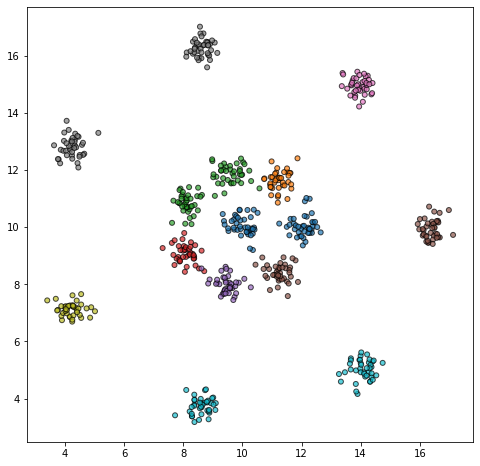

In [11]:
size=8
plt.figure(figsize=(size,size))
plt.scatter(X[:, 0], X[:, 1],
            s=25, 
            c=y,
            marker="o",
            cmap='tab10',
            norm=None,
            alpha=.7,
            edgecolor="k")

In [12]:
rips_complex = gudhi.RipsComplex(points=X)

In [13]:
simplex_tree = rips_complex.create_simplex_tree(max_dimension=1)
   
print(simplex_tree.num_vertices() , 'vertices')  
print(simplex_tree.num_simplices(), 'simplices')
print('dimension:', simplex_tree.dimension())

600 vertices
180300 simplices
dimension: 1


usetex mode requires TeX.


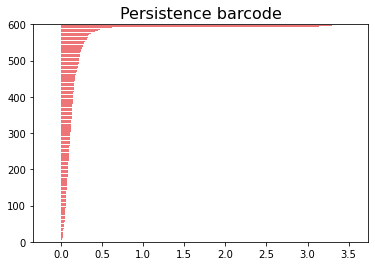

In [14]:
diag = simplex_tree.persistence()
gudhi.plot_persistence_barcode(diag)
plt.show()

In [15]:
#move through list and assign clusters to conected components
point_dict={i:0 for i in range(simplex_tree.num_vertices())}
counter=0
cluster_dict_list = []
distance_list = []
for simplex in simplex_tree.get_filtration():
    if len(simplex[0])>1:
        if all(value > 0 for value in list(point_dict.values())):
            if len(np.unique(np.array(list(point_dict.values())))) == 1:
                print('break')
                print(simplex)
                print(simplex[1])
                simplex_tree.prune_above_filtration(simplex[1])
                break


        #if both points are still in cluster 0, assign both to a new cluster
        if point_dict[simplex[0][0]] == 0 and point_dict[simplex[0][1]] == 0:
            counter += 1
            point_dict[simplex[0][0]] = counter
            point_dict[simplex[0][1]] = counter
            #if one point is in cluster 0 and one is not, assign the one in cluster 0 to the existing cluster
        elif point_dict[simplex[0][0]] == 0 and point_dict[simplex[0][1]] != 0:
            point_dict[simplex[0][0]] = point_dict[simplex[0][1]]

            #and vice versa
        elif point_dict[simplex[0][0]] != 0 and point_dict[simplex[0][1]] == 0:
            point_dict[simplex[0][1]] = point_dict[simplex[0][0]]

            #if both points are not in cluster 0 and not in the same cluster, merge clusters to the lower number cluster
        elif point_dict[simplex[0][0]] != 0 and point_dict[simplex[0][1]] != 0 and point_dict[simplex[0][0]] != point_dict[simplex[0][1]]:
            larger_cluster_number = max(point_dict[simplex[0][0]], point_dict[simplex[0][1]])
            smaller_cluster_number = min(point_dict[simplex[0][0]], point_dict[simplex[0][1]])
            for key, value in point_dict.items():
                if value == larger_cluster_number:
                    point_dict[key] = smaller_cluster_number
                    
        distance_list.append(simplex[1])
        cluster_dict_list.append(point_dict.copy())

break
([72, 278], 3.394113728206525)
3.394113728206525


In [16]:
max(distance_list)

3.394080729741118

In [17]:
len(distance_list)

42270

In [18]:
distance_array = np.array(distance_list)
print(len(distance_array))
distance_array.dtype

42270


dtype('float64')

In [19]:
length = len(cluster_dict_list)
length

42270

In [20]:
print(simplex_tree.num_simplices(), 'simplices')
#?

42871 simplices


In [21]:
#check that all clusters have merged
len(np.unique(np.array(list(point_dict.values()))))

1

In [22]:
#print(cluster_dict_list[-2].values()) #penultimate clustering has 2 clusters
#print(cluster_dict_list[-1].values()) #last clustering finally merges to all one cluster

In [23]:
#find the gaps between birth/death pairs
gaps = np.diff(distance_array)
gaps.shape

(42269,)

In [24]:
#add a zero back to the beginning of the gaps
gaps = np.concatenate([np.zeros(1),gaps])

In [25]:
#find normalized distance
scaler = MinMaxScaler()
normed_distance = scaler.fit_transform(distance_array.reshape(-1,1)).T.reshape(length)

In [26]:
#then invert them and multiply by the gaps to weight early connections in the filtration
inverted_normed_distance = 1 - normed_distance
inverted_normed_distance

array([1.00000000e+00, 9.99755776e-01, 9.99271204e-01, ...,
       3.42227812e-05, 1.05967767e-05, 0.00000000e+00])

In [27]:
normed_gaps = np.multiply(gaps, inverted_normed_distance)
normed_gaps

array([0.00000000e+00, 8.28224803e-04, 1.64251090e-03, ...,
       1.67386028e-09, 8.49239617e-10, 0.00000000e+00])

In [28]:
#normalize to create a probability vector
gap_vector = normed_gaps / np.sum(normed_gaps)

In [29]:
#check
np.sum(gap_vector)

0.9999999999999999

In [30]:
gap_vector

array([0.00000000e+00, 4.88358658e-04, 9.68498427e-04, ...,
       9.86983436e-10, 5.00749939e-10, 0.00000000e+00])

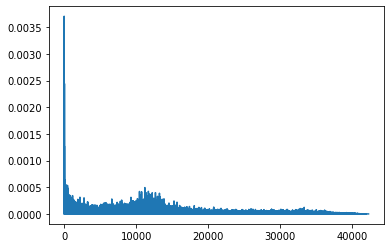

In [31]:
plt.plot(gap_vector)

In [32]:
marker = 0
for i in range(1,length-1):
    if cluster_dict_list[marker] == cluster_dict_list[i]:

        gap_vector[marker] += gap_vector[i]
        gap_vector[i] = 0
        #print(marker)


    else:
        marker = i

1.0000000000000047


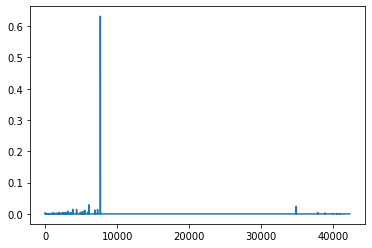

In [33]:
print(np.sum(gap_vector))
plt.plot(gap_vector)

In [34]:
candidates = np.flip(np.argsort(gap_vector))

In [35]:
candidates[0]

7643

In [36]:
gap_vector[candidates[0]]

0.6318600580212643

In [37]:
idx = candidates[0]
idx

7643

In [38]:
pred = np.array(list(cluster_dict_list[idx].values()))

In [39]:
print(gap_vector[idx])
print('percent confidence')
'{:.1%}'.format(gap_vector[idx])

0.6318600580212643
percent confidence


'63.2%'

In [40]:
np.array(list(cluster_dict_list[idx].values()))

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1

In [41]:
#cluster_idx_array = (np.unique(np.array(list(cluster_dict_list[idx].values()))))
#print(cluster_idx_array)
#print(np.count_nonzero(cluster_idx_array))

number_of_clusters = np.count_nonzero(np.unique(np.array(list(cluster_dict_list[idx].values()))))
print(number_of_clusters)
print('your dataset appears to have', number_of_clusters,'clusters, not including any outliers')
#return counts from np.unique? to filter out small clusters?

8
your dataset appears to have 8 clusters, not including any outliers


In [42]:
true = y

print(metrics.adjusted_rand_score(true, pred))
print(metrics.silhouette_score(X, pred, metric="sqeuclidean"))

0.2636754763368162
0.7808281507901929


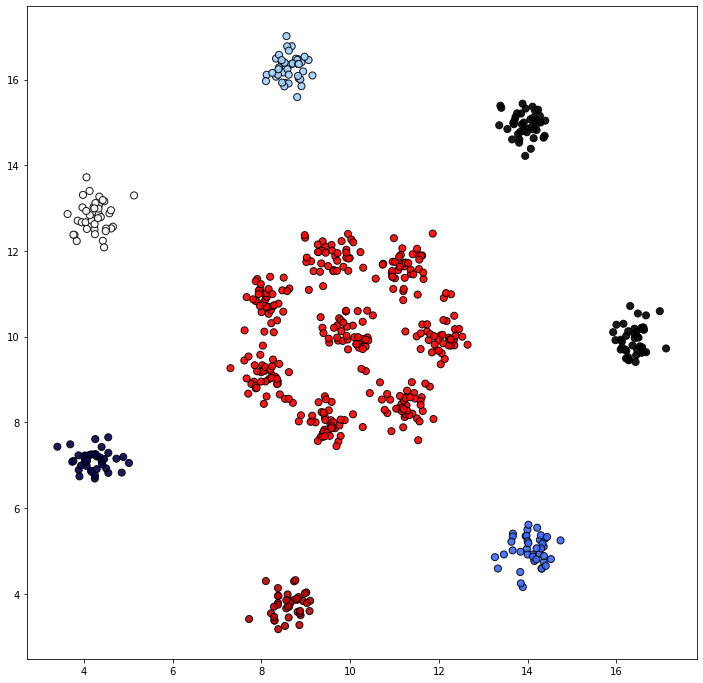

In [43]:
size=12
plt.figure(figsize=(size,size))
plt.scatter(X[:, 0], X[:, 1],
            s=50, 
            c=np.array(list(cluster_dict_list[idx].values())),
            marker="o",
            cmap='flag',
            norm=None,
            alpha=.9,
            edgecolor="k")

In [44]:
idx_list = candidates[:100]

In [45]:
idx_list.sort()

In [64]:
idx_list = [x for x in idx_list if x < idx]

In [65]:
idx_array = np.asarray(idx_list)
idx_array

array([   2,    3,    4,    7,    8,   19,   23,   31,   33,   37,   38,
         41,   54,  129,  224,  338,  460,  469,  627,  776,  824,  837,
        914,  929,  955,  977, 1009, 1045, 1062, 1082, 1118, 1140, 1171,
       1222, 1254, 1277, 1323, 1341, 1377, 1452, 1513, 1533, 1575, 1617,
       1655, 1683, 1708, 1754, 1788, 1815, 1851, 1872, 1903, 2019, 2034,
       2066, 2116, 2145, 2185, 2208, 2244, 2297, 2315, 2380, 2452, 2541,
       2567, 2606, 2708, 2739, 2759, 2781, 2933, 3018, 3112, 3145, 3187,
       3452, 3481, 3613, 3744, 3807, 4297, 4346, 4837, 4962, 5160, 5236,
       5481, 5887, 6053, 6889])

In [66]:
silhouette_list = []
for i in idx_list:
    silhouette = metrics.silhouette_score(X, np.array(list(cluster_dict_list[i].values())), metric="euclidean")
    silhouette_list.append(silhouette)

In [67]:
silhouette_array = np.asarray(silhouette_list)

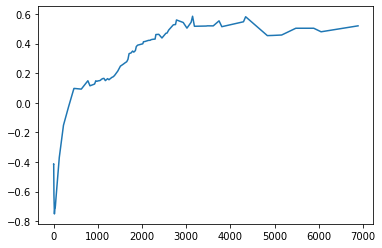

In [68]:
plt.plot(idx_array,silhouette_array)

In [69]:
max(silhouette_array)

0.5850524066920552

In [70]:
max_idx = silhouette_array.argmax()

In [71]:
idx = idx_array[max_idx]
idx

3145

In [72]:
#idx = silhouette_scores.index(max(silhouette_scores[simplex_tree.num_vertices():idx]))
#print(idx)

In [73]:
rand_score_list = []
true = y
for i in idx_list:
    pred = np.array(list(cluster_dict_list[i].values()))
    rand_score = metrics.adjusted_rand_score( true, pred)
    rand_score_list.append(rand_score)

In [74]:
rand_score_array = np.asarray(rand_score_list)

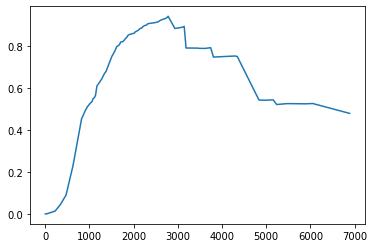

In [75]:
 plt.plot(idx_array,rand_score_array)

In [76]:
max(rand_score_array)

0.9402441277383992

In [77]:
pred = np.array(list(cluster_dict_list[idx].values()))
pred

array([  9,   9,   9,   9,   9,   9,   9,   9,   9,   9,   9,   9,   9,
         9,   9,   9,   9,   9,   9,   9,   9,   9,   9, 143,   9,   9,
         9,   9,   9,   9,   9,   9,   9,   9,   9,   9,   9,   9,   9,
       143,  19,  19,  19,  19,  19,  19,  19,  19,  19,  19,  19, 147,
        19,  19,  19,  19,  19,  19,  19,  19,  19,  19,  19,  19,  19,
       147,  19,  19, 147,  19,  19,  19,  19,  19,  19,  19,  19,  19,
        19,  19,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,
         7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,
         7,   7,   7,   7,   7,   7,   7,   0,   7,   7,   7,   7,   7,
         7,   7,   7,   1,   1,   1,   1,   1,   1,   1,   0,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   0,   5,   5,   5,   5,   5,   5,   5,   5,   5,
         5,   5,   5,   5,   5,   5,   5,   5,   5,   5,   5,   

In [78]:
masked = np.ma.masked_where(pred == 0,pred)
masked

masked_array(data=[9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
                   9, 9, 9, 9, 9, 143, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
                   9, 9, 9, 143, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19,
                   19, 147, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19,
                   19, 19, 147, 19, 19, 147, 19, 19, 19, 19, 19, 19, 19,
                   19, 19, 19, 19, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
                   7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
                   --, 7, 7, 7, 7, 7, 7, 7, 7, 1, 1, 1, 1, 1, 1, 1, --, 1,
                   1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
                   1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, --, 5, 5, 5, 5, 5,
                   5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
                   --, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
                   5, 5, 5, 5, 5, 5, --, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
                   5, 5, 5, 5, 5, 5, 5, 5, 5

In [79]:
cmap = plt.cm.get_cmap("prism").copy()

cmap.set_bad(cmap(0))

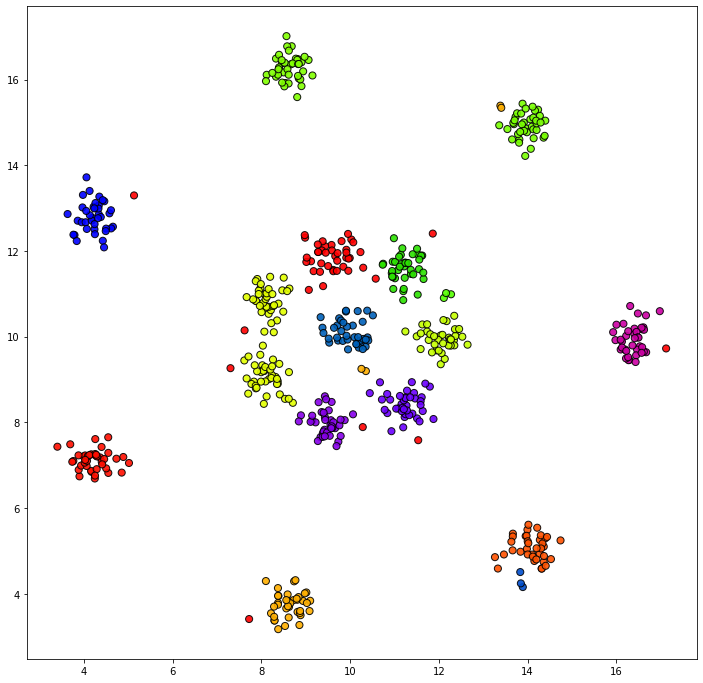

In [80]:
size=12
plt.figure(figsize=(size,size))
plt.scatter(X[:, 0], X[:, 1],
            s=50, 
            c=pred,
            marker="o",
            cmap=cmap,
            norm=None,
            alpha=.9,
            edgecolor="k")

plt.show()

<ipython-input-63-e5bccb1d58cf>:51: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


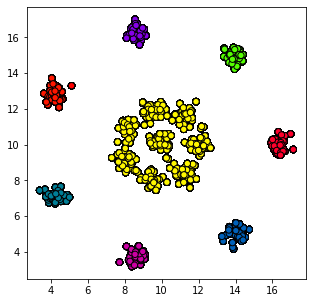

In [63]:
fig, ax = plt.subplots(figsize=(5,5))
frames = len(idx_array)


outfile = filename + str(frames) + 'frames.gif'

if not os.path.isfile(outfile):
    def init():
        scatter = ax.scatter(X[:, 0], X[:, 1],
                        s=40, 
                        c=np.array(list(cluster_dict_list[0].values())),
                        marker="o",
                        cmap=cmap,
                        norm=None,
                        alpha=1,
                        edgecolor="k")
        #ax.set(xlim=(-1, 35), ylim=(-1, 35))

        return scatter,

    #collection = PatchCollection(X, animated=True)

    #ax.add_collection(collection)
    #ax.autoscale_view(True)

    def animate(i):

        scatter = ax.scatter(X[:, 0], X[:, 1],
                    s=40, 
                    c=np.array(list(cluster_dict_list[idx_array[i]].values())),
                    marker="o",
                    cmap='prism',
                    norm=None,
                    alpha=1,
                    edgecolor="k")
        return scatter,



    ani = FuncAnimation(fig, animate,interval=100,init_func=init,frames=frames,repeat=False, blit=True)

    #ani.save('animation.gif')



    #writer=animation.PillowWriter()

    #writer = animation.FFMpegWriter(fps=2,bitrate=1000)

    ani.save(outfile, dpi=200)
    fig.show()


def pogo(dataset):
    rips_complex = gudhi.RipsComplex(points=dataset,max_edge_length=100)
    simplex_tree = rips_complex.create_simplex_tree(max_dimension=1)
    df = pd.DataFrame(simplex_tree.get_filtration(), columns=['simplex','distance'])
    #move through list and assign clusters to conected components

    point_dict={i:0 for i in range(simplex_tree.num_vertices())}
    counter=0

    cluster_dict_list = []
    for i in range(simplex_tree.num_vertices(),len(df)):
        #if both points are still in cluster 0, assign both to a new cluster
        if point_dict[df.loc[i,'simplex'][0]] == 0 and point_dict[df.loc[i,'simplex'][1]] == 0:
            counter += 1
            point_dict[df.loc[i,'simplex'][0]] = counter
            point_dict[df.loc[i,'simplex'][1]] = counter
            #if one point is in cluster 0 and one is not, assign the one in cluster 0 to the existing cluster
        elif point_dict[df.loc[i,'simplex'][0]] == 0 and point_dict[df.loc[i,'simplex'][1]] != 0:
            point_dict[df.loc[i,'simplex'][0]] = point_dict[df.loc[i,'simplex'][1]]

            #and vice versa
        elif point_dict[df.loc[i,'simplex'][0]] != 0 and point_dict[df.loc[i,'simplex'][1]] == 0:
            point_dict[df.loc[i,'simplex'][1]] = point_dict[df.loc[i,'simplex'][0]]

            #if both points are not in cluster 0 and not in the same cluster, merge clusters to the lower number cluster
        elif point_dict[df.loc[i,'simplex'][0]] != 0 and point_dict[df.loc[i,'simplex'][1]] != 0 and point_dict[df.loc[i,'simplex'][0]] != point_dict[df.loc[i,'simplex'][1]]:
            larger_cluster_number = max(point_dict[df.loc[i,'simplex'][0]], point_dict[df.loc[i,'simplex'][1]])
            smaller_cluster_number = min(point_dict[df.loc[i,'simplex'][0]], point_dict[df.loc[i,'simplex'][1]])
            for key, value in point_dict.items():
                if value == larger_cluster_number:
                    point_dict[key] = smaller_cluster_number
        cluster_dict_list.append(point_dict.copy())
        #print(point_dict)
        #print('step',i)

    
    cutoff_value = 0
    for i in range(len(cluster_dict_list)):
        if cutoff_value == 0:
            if all(value != 0 for value in cluster_dict_list[i].values()):
                cutoff_value = i
                print('dataset becomes connected at simplex #',cutoff_value)
       
    df = df[:cutoff_value]
    #cluster_dict_list =
    
    #find the gaps between birth/death pairs

    df['gaps'] = df['distance'] - df['distance'].shift(1)
    
    #find normalized distance
    scaler = MinMaxScaler()
    df['normed_distance'] = scaler.fit_transform(df['distance'].values.reshape(-1, 1))

    #Mulitply the gaps by their normed location in the filtration, weighting features more heavily if they're later
    df['normed_gaps'] = df['gaps'] * df['normed_distance']

    norm_sum = df['normed_gaps'].sum()
    df['probability_vector_normed_gaps'] = df['normed_gaps'] / norm_sum
    
    gap_sum = df['gaps'].sum()
    df['probability_vector_gaps'] = df['normed_gaps'] / gap_sum

    partition = 10
    candidates = [i for i in df.nlargest(partition ,['gaps']).index if i in df.nlargest( partition,['normed_gaps']).index]
    #print('possible cuttoffs' , candidates)
    idx = cutoff_value - 1
    #idx = candidates[0]
    print('idx' ,idx)

    print('your dataset appears to have', len(np.unique(np.array(list(cluster_dict_list[idx].values())))),'clusters')

    #print( np.array(list(cluster_dict_list[idx].values())))

    print(simplex_tree.num_vertices() , 'vertices')  
    print(simplex_tree.num_simplices(), 'simplices')
    print('dimension:', simplex_tree.dimension())

    size=10
    plt.figure(figsize=(size,size))
    plt.scatter(dataset[:, 0], dataset[:, 1],
                s=30, 
                c=np.array(list(cluster_dict_list[idx].values())),
                marker="o",
                cmap='rainbow',
                norm=None,
                alpha=.9,
                edgecolor="k")
    
    return cluster_dict_list, candidates, idx


cluster_dict_list, candidates, idx = pogo(X)

true = y
pred = np.array(list(cluster_dict_list[idx].values()))

print('adjusted rand score =' , metrics.adjusted_rand_score(true, pred))
